In [1]:
%matplotlib inline


Basis functions
===============
In the previous tutorial we have seen that overlapping even-related time courses
can be recovered using the general linear model, as long as we assume they add up
linearly and are time-invariant.




In [2]:
# Import libraries and setup plotting
from nideconv.utils import double_gamma_with_d
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook')

/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Well-specified model
--------------------
Another important assumption pertains to what we believe the response we are 
interested in looks like. In the most extreme case, we for example assume that a
task-related BOLD fMRI response exactly follows the canonical HRF.



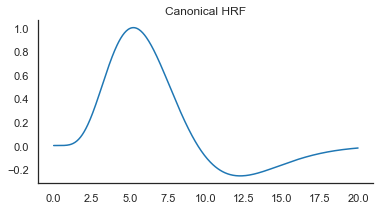

In [3]:
plt.figure(figsize=(6,3))
t = np.linspace(0, 20, 500)
plt.plot(t, double_gamma_with_d(t))
plt.title('Canonical HRF')
sns.despine()

Let’s simulate some data with very little noise and the standard HRF, 
fit a model, and see how well our model fits the data 



/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)


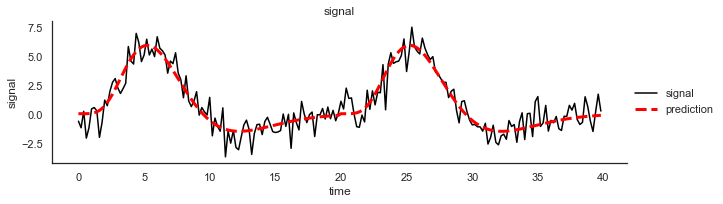

In [4]:
from nideconv import simulate
from nideconv import ResponseFitter

conditions = [{'name':'A',
              'mu_group':5.,
              'std_group':1,
               'onsets':[0, 20]}]

# Simulate data with very short run time and TR for illustrative purposes
data, onsets, pars = simulate.simulate_fmri_experiment(conditions,
                                                       TR=0.2,
                                                       run_duration=40,
                                                       n_rois=1)

# Make ResponseFitter-object to fit these data
rf = ResponseFitter(input_signal=data,
                    sample_rate=5) # Sample rate is inverse of TR (1/TR)
rf.add_event('A',
             onsets.loc['A'].onset,
             interval=[0, 20],
             basis_set='canonical_hrf')

rf.fit()

rf.plot_model_fit()

As you can see, the model fits the data well, the model is well-specified. 



Mis-specified model
--------------------
Now let’s what happens with data with different HRF from what the model 
assumes.



Text(0.5, 0, 'time (s)')

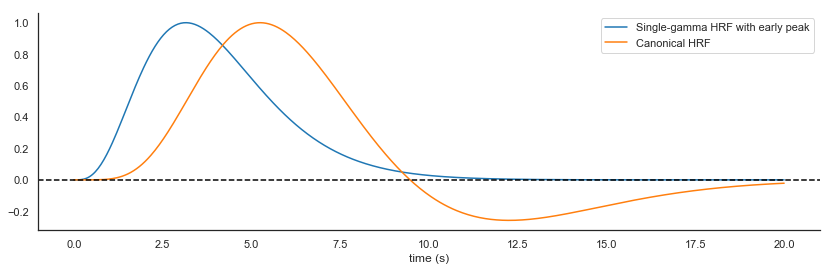

In [5]:
# For this HRF the first peak is much earlier (approx 3.5 seconds versus 5.8)
# and the second "dip" is not there (c=0).
kernel_pars = {'a1':3.5,
               'c':0}

plt.plot(t, double_gamma_with_d(t, **kernel_pars), label='Single-gamma HRF with early peak')
plt.plot(t, double_gamma_with_d(t), label='Canonical HRF')
plt.axhline(0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(14, 4)
plt.legend()
plt.xlabel('time (s)')

Simulate data again



In [6]:
sns.set_context('poster')

In [51]:
kernel_pars = {'a1':3.5, 'c':0.}

conditions = [{'name':'stimulation',
              'mu_group':10.,
              'std_group':0.,
               'onsets':[0, 20],
               'kernel':'double_gamma',
                'kernel_pars':kernel_pars}]


np.random.seed(256)
data, onsets, pars = simulate.simulate_fmri_experiment(conditions,
                                                       TR=0.2,
                                                       run_duration=50,
                                                       n_rois=1,
                                                       kernel_pars=kernel_pars)

data /= 10.

rf = ResponseFitter(input_signal=data,
                    sample_rate=5)
rf.add_event('stimulation',
             onsets.loc['stimulation'].onset,
             interval=[0, 20],
             basis_set='canonical_hrf')

/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)


Plot the model fit



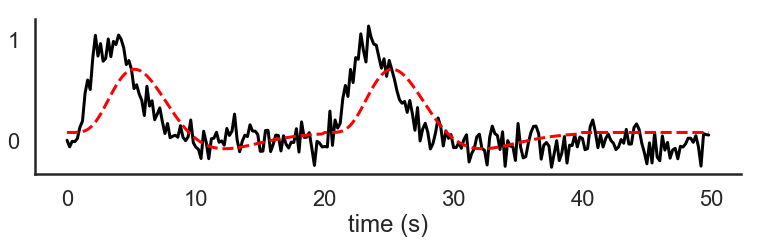

In [52]:
rf.fit()
rf.plot_model_fit(legend=False)
plt.title('')
plt.ylabel('')
plt.xlabel('time (s)')

legend_strings = ['Measured timeseries', 'Predicted timeseries']
# plt.legend(legend_strings)

plt.gcf().set_size_inches(12, 6)

plt.savefig('/Users/gilles/git/hbm2019_nideconv/figures/misestimation_chrf.pdf', transparent=True)

And the estimated time course



/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


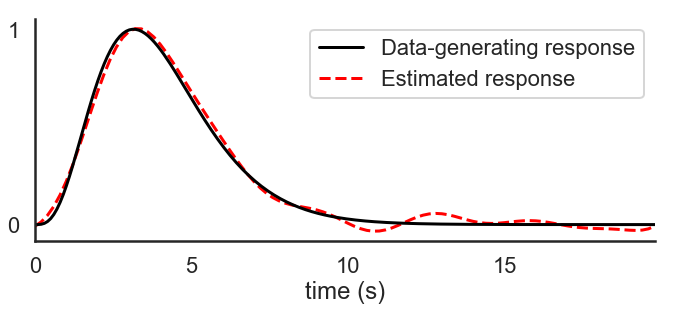

In [68]:
def plot_estimated_and_actual_tc(rf, 
                                 kernel_pars=kernel_pars,
                                 amplitudes=[1.],
                                legend=True):
    """
    Plots estimated event-related responses plus the actual underlying
    responses given by kernel_pars and amplitudes
    """
    
    t = np.linspace(0, 20, 200, endpoint=True)

    # Allow for plotting multiple amplitudes
    amplitudes = np.array(amplitudes)

    sns.set_palette(['red'])
    rf.plot_timecourses(legend=False, extra_axes=False, oversample=1, ls='--')
    
    plt.plot(t, 
         double_gamma_with_d(t, **kernel_pars)[:, np.newaxis] * amplitudes,
         label='Actual response', color='k')


    
    if legend:
        legend_strings = ['Estimated response', 'Data-generating response']
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], legend_strings[::-1])
#     plt.suptitle('Estimated event-related response')
#     plt.tight_layout()



plot_estimated_and_actual_tc(rf, legend=True)

plt.xlabel('time (s)')
plt.suptitle('')
plt.yticks([0, 1])
plt.xticks(np.arange(0, 20, 5))

plt.gcf().set_size_inches((12, 6))

plt.savefig('/Users/gilles/git/hbm2019_nideconv/figures/misestimation_chrf.pdf', transparent=True)


/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


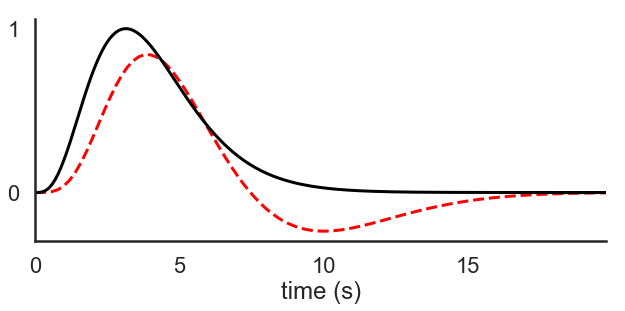

In [77]:
rf = ResponseFitter(input_signal=data,
                    sample_rate=5)
rf.add_event('stimulation',
             onsets.loc['stimulation'].onset,
             interval=[0, 20],
             basis_set='canonical_hrf_with_time_derivative')

rf.fit()

plot_estimated_and_actual_tc(rf, legend=False)

plt.xlabel('time (s)')
plt.suptitle('')
plt.yticks([0, 1])
plt.xticks(np.arange(0, 20, 5))

plt.gcf().set_size_inches((12, 6))

plt.savefig('/Users/gilles/git/hbm2019_nideconv/figures/misestimation_chrfd.pdf', bbox_inches='tight', transparent=True)

/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)
/Users/gilles/git/nideconv/nideconv/regressors.py:252: UserWarning: Number of FIR regressors has automatically been set to 100 per covariate
  'per covariate' % self.n_regressors)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


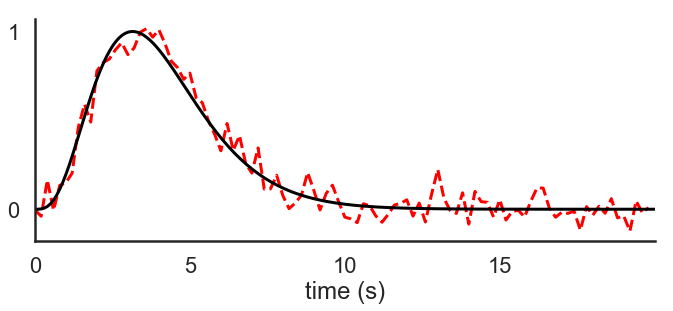

In [76]:
rf = ResponseFitter(input_signal=data,
                    sample_rate=5)
rf.add_event('stimulation',
             onsets.loc['stimulation'].onset,
             interval=[0, 20],
             basis_set='fir')

rf.fit()

plot_estimated_and_actual_tc(rf, legend=False)

plt.xlabel('time (s)')
plt.suptitle('')
plt.yticks([0, 1])
plt.xticks(np.arange(0, 20, 5))
plt.xlim(0, 20)


plt.gcf().set_size_inches((12, 6))

plt.savefig('/Users/gilles/git/hbm2019_nideconv/figures/misestimation_fir.pdf', bbox_inches='tight', transparent=True)

/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


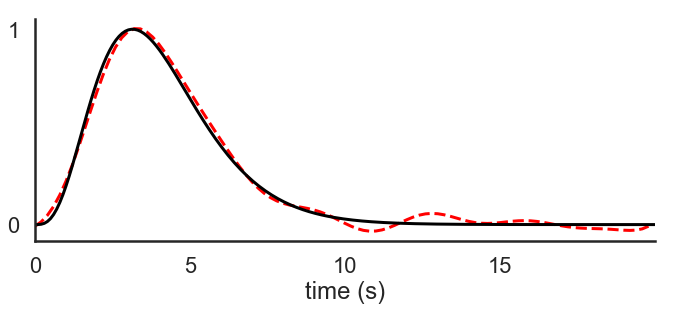

In [75]:
rf = ResponseFitter(input_signal=data,
                    sample_rate=5)
rf.add_event('stimulation',
             onsets.loc['stimulation'].onset,
             interval=[0, 20],
             n_regressors=13,
             basis_set='fourier')

rf.fit()

plot_estimated_and_actual_tc(rf, legend=False)

plt.xlabel('time (s)')
plt.suptitle('')
plt.yticks([0, 1])
plt.xticks(np.arange(0, 20, 5))
plt.xlim(0, 20)

plt.gcf().set_size_inches((12, 6))


plt.savefig('/Users/gilles/git/hbm2019_nideconv/figures/misestimation_fourier.pdf', bbox_inches='tight', transparent=True)

Clearly, the model now does not fit very well. This is because the design 
matrix $X$ does not allow for properly modelling the event-related 
time course. 
No matter what linear combination $\beta$ you take of the intercept 
and canonical HRF (that has been convolved with the event onsets), 
the data can never be properly explained.



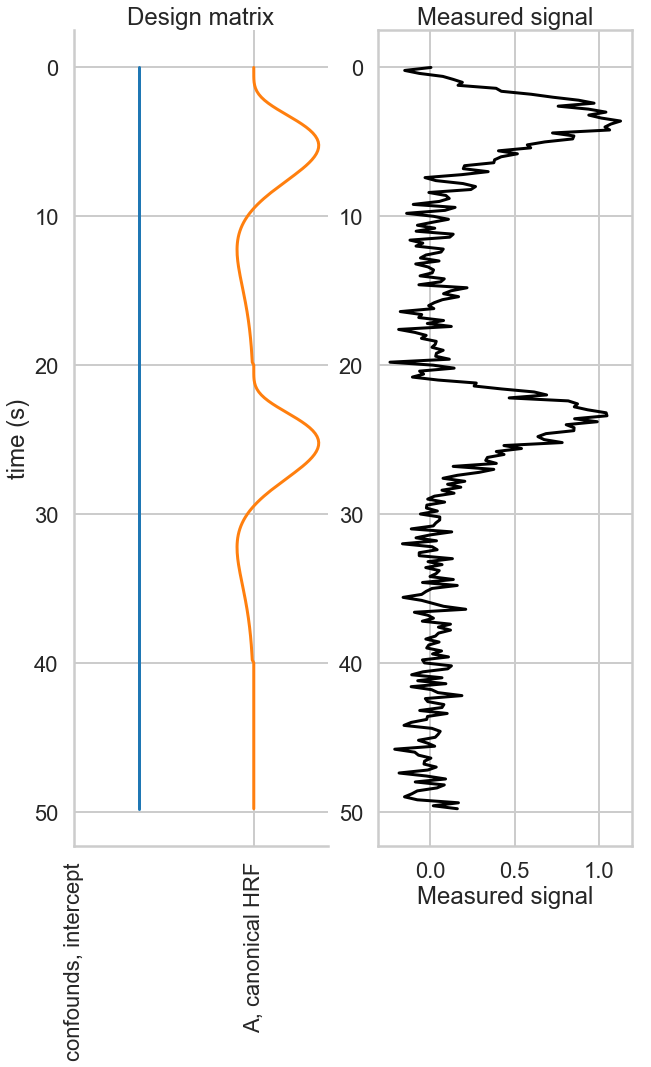

In [26]:
def plot_design_matrix(rf):
    """
    Plots the design matrix of rf in left plot, plus the signal
    it should explain in the right plot.
    Time is in the vertical dimension. Each regressor in X is plotted
    as a seperate line.
    """
    sns.set_style('whitegrid')
    ax = plt.subplot(121)
    rf.plot_design_matrix()

    plt.title('Design matrix')

    plt.subplot(122, sharey=ax)
    plt.plot(rf.input_signal, rf.input_signal.index, c='k')
    plt.title('Measured signal')
    plt.xlabel('Measured signal')

    plt.gcf().set_size_inches(10,15)
    sns.set_style('white')

plot_design_matrix(rf)

The derivative of the cHRF with respect to time
-----------------------------------------------
The solution to this mis-specification is to increase the model complexity 
by adding extra regressors that increase the flexibility of the model. A 
very standard approach in BOLD fMRI is to include the derivative of the 
HRF with respect to time for dt=0.1. Then the design matrix looks like this



/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)


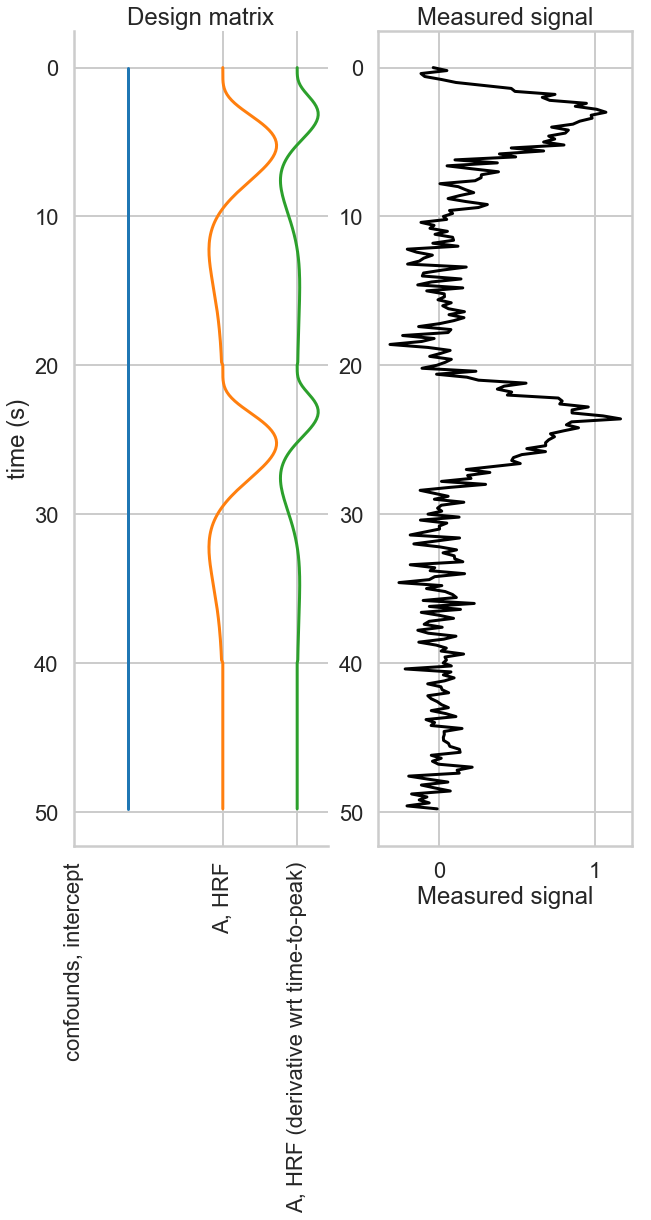

In [97]:
rf = ResponseFitter(input_signal=data, sample_rate=5)
rf.add_event('A',
             onsets.loc['A'].onset,
             interval=[0, 20],
             basis_set='canonical_hrf_with_time_derivative') # note the more complex
                                                             # basis function set

plot_design_matrix(rf)

The GLM can now “use the new, red regressor” to somewhat shift the 
original HRF earlier in time.



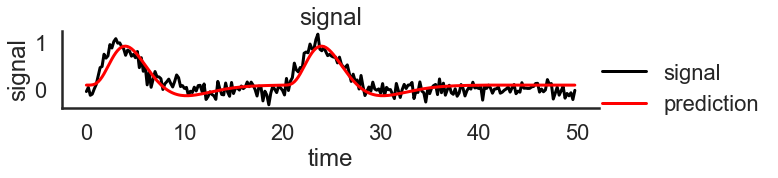

In [98]:
rf.fit()
rf.plot_model_fit()

In [ ]:
def plot_estimated_and_actual_tc(rf, 
                                 kernel_pars=kernel_pars,
                                 amplitudes=[1.]):
    """
    Plots estimated event-related responses plus the actual underlying
    responses given by kernel_pars and amplitudes
    """
    
    t = np.linspace(0, 20, 200, endpoint=True)

    # Allow for plotting multiple amplitudes
    amplitudes = np.array(amplitudes)

    sns.set_palette(['red'])
    rf.plot_timecourses(legend=False, extra_axes=False, ls='--')
    
    plt.plot(t, 
         double_gamma_with_d(t, **kernel_pars)[:, np.newaxis] * amplitudes,
         label='Actual response', color='k')

    legend_strings = list(['Estimated response', 'Data-generating response'])
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], legend_strings[::-1])
#     plt.suptitle('Estimated event-related response')
#     plt.tight_layout()



plot_estimated_and_actual_tc(rf)

plt.xlabel('time (s)')
plt.suptitle('')
plt.yticks([0, 1])
plt.xticks(np.arange(0, 20, 5))

plt.gcf().set_size_inches((12, 6))

plt.savefig('/Users/gilles/nideconv/misestimation_chrf.pdf', transparent=True)

/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


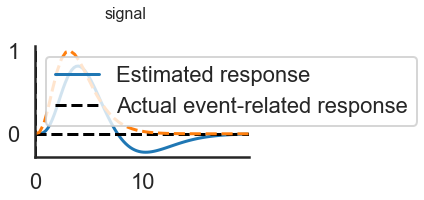

In [99]:
plot_estimated_and_actual_tc(rf)

Even more complex basis functions
---------------------------------
Note that the model still does not fit perfectly: the Measured signal is 
still peaking earlier in time than the model. And the model still assumes 
as post-peak dip that is not there in the data.

One solution is to use yet more complex basis functions, such as the 
Finite Impulse Response functions we used in the previous tutorial. This 
basis functions consists of one regressor per time-bin (as in time 
offset since event).



/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)


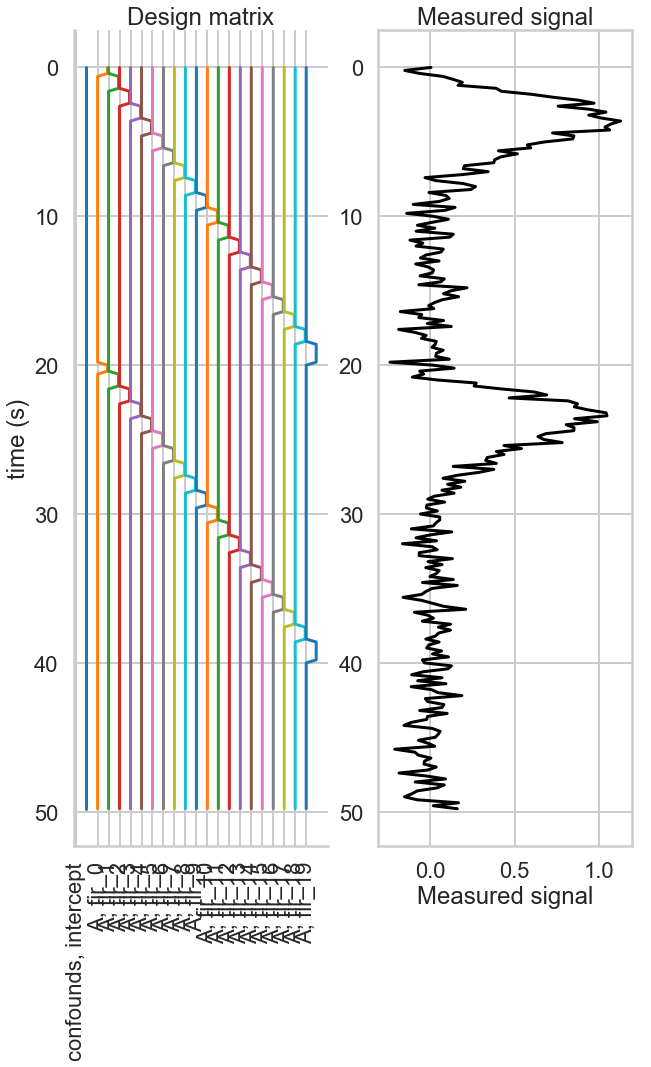

In [30]:
rf = ResponseFitter(input_signal=data,
                    sample_rate=5)
rf.add_event('A',
             onsets.loc['A'].onset,
             interval=[0, 20],
             basis_set='fir',
             n_regressors=20) # One regressor per second

plot_design_matrix(rf)

Clearly, this model is much more flexible, and, hence, it fits better:



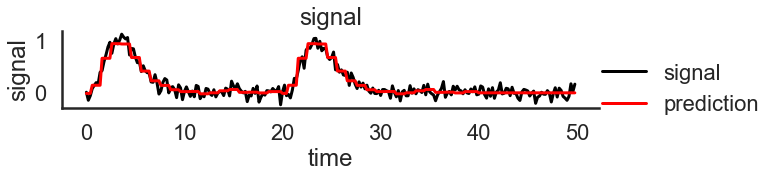

In [31]:
rf.fit()
rf.plot_model_fit()

Clearly, this model is much more flexible, and, hence, it fits better:



/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


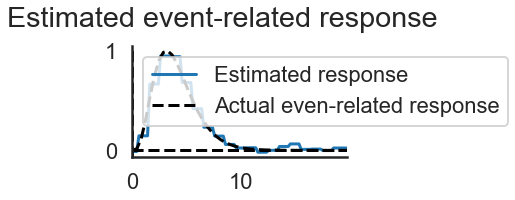

In [32]:
plot_estimated_and_actual_tc(rf)

No Free Lunch (Bias-Variance tradeoff)
--------------------------------------
The higher flexibility of the FIR model is due to its higher 
*degrees-of-freedom*, roughly the number of regressors.
It is important to note that a higher number of degrees-of-freedom
also mean a higher *variance* of the model. A higher variance means
that smaller fluctuations in the data will lead to larger differences
in parameter estimates.
This is especially problematic in high-noise regimes. The following
simulation will show this.

Simulation
~~~~~~~~~~



In [33]:
# Set a random seed so output will always be the same
np.random.seed(666)

# Simulate data
TR = 0.55
sample_rate = 1./TR
data, onsets, pars = simulate.simulate_fmri_experiment(noise_level=2.5,
                                                       TR=TR,
                                                       run_duration=1000,
                                                       n_trials=100,
                                                       kernel_pars=kernel_pars)
# cHRF model
hrf_model = ResponseFitter(data, sample_rate)
hrf_model.add_event('A', onsets.loc['A'].onset, interval=[0, 20], basis_set='canonical_hrf')
hrf_model.add_event('B', onsets.loc['B'].onset, interval=[0, 20], basis_set='canonical_hrf')

# cHRF model with derivative wrt time-to-peak
hrf_dt_model = ResponseFitter(data, sample_rate)
hrf_dt_model.add_event('A', onsets.loc['A'].onset, interval=[0, 20], basis_set='canonical_hrf_with_time_derivative')
hrf_dt_model.add_event('B', onsets.loc['B'].onset, interval=[0, 20], basis_set='canonical_hrf_with_time_derivative')

# FIR_model
fir_model = ResponseFitter(data, sample_rate)
fir_model.add_event('A', onsets.loc['A'].onset, interval=[0, 20])
fir_model.add_event('B', onsets.loc['B'].onset, interval=[0, 20])

{}
{}


/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0.  19.8].
  warnings.warn(warning)
/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0.  19.8].
  warnings.warn(warning)
/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0.  19.8].
  warnings.warn(warning)
/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0.  19.8].
  warnings.warn(warning)
/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0.  19.8].
  warnings.warn(warning)
/Users/gilles/git/nideconv/nideconv/regressors.py:252: UserWarning: Number of FIR regressors has automatically been set to 36 per covariate
  'per covariate' % self.n_regressors)
/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically se

Simplest model (cHRF)
~~~~~~~~~~~~~~~~~~~~~



/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


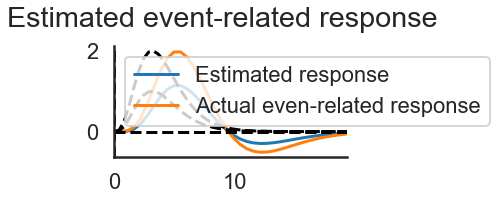

In [34]:
hrf_model.fit()
plot_estimated_and_actual_tc(hrf_model,
                             amplitudes=pars.amplitude.tolist())

Extend model (cHRF + deriative wrt time)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


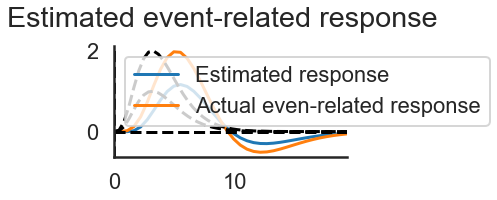

In [35]:
hrf_dt_model.fit()
plot_estimated_and_actual_tc(hrf_dt_model,
                             amplitudes=pars.amplitude.tolist())

Most complex model (FIR)
~~~~~~~~~~~~~~~~~~~~~~~~



/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


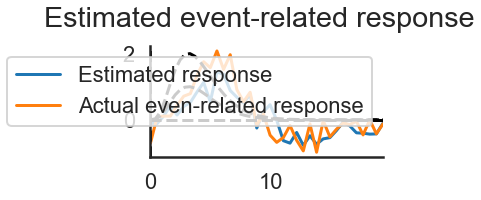

In [36]:
fir_model.fit()
plot_estimated_and_actual_tc(fir_model,
                             amplitudes=pars.amplitude.tolist())

The price of complexity
-----------------------
As you can see, the simplest model does not perform very well, because
it is mis-specified to such a large degree.
However, the most complex model (FIR) also does not perform very well:
the estimated event-related time course is extremely noisy and it
looks very "spiky".
The cHRF that includes a derivative wrt to time also doesn't perform
perfectly, because it assume as post-peak undershoot.

Another basis function set that is quite useful for slow, smooth time courses
like fMRI BOLD and the pupil is the *Fourier set*.
It consists of an intercept and sine-cosine pairs of increasing
frequency.



{}


/Users/gilles/git/nideconv/nideconv/regressors.py:230: UserWarning: 
Interval is now automatically set to [ 0. 20.].
  warnings.warn(warning)


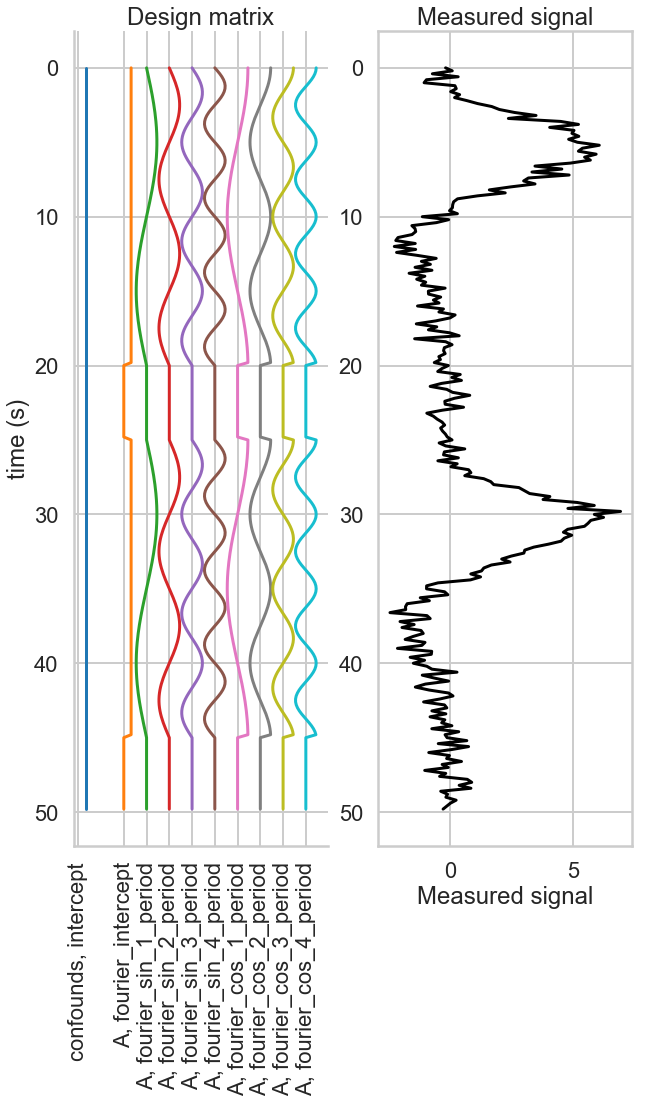

In [37]:
conditions = [{'name':'A',
              'mu_group':5,
              'std_group':1,
               'onsets':[0, 25]}]

TR = 0.2
sample_rate = 1./TR

data, onsets, pars = simulate.simulate_fmri_experiment(conditions,
                                                       TR=TR,
                                                       run_duration=50,
                                                       noise_level=.5,
                                                       n_rois=1,
                                                       kernel_pars=kernel_pars)

fourier_model = ResponseFitter(data, sample_rate)
fourier_model.add_event('A', 
                        onsets.loc['A'].onset,
                        basis_set='fourier',
                        n_regressors=9,
                        interval=[0, 20])
plot_design_matrix(fourier_model)

/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


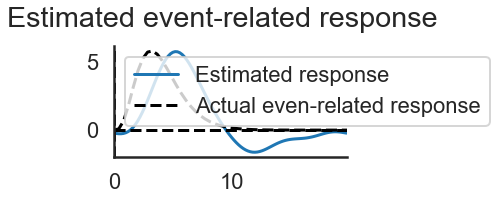

In [38]:
fourier_model.fit()
plot_estimated_and_actual_tc(fourier_model,
                             amplitudes=pars.amplitude.tolist())

Smoothness constraint
~~~~~~~~~~~~~~~~~~~~~
The Fourier model combines the flexibility of the FIR model, with a
lower number of degrees of freedom. It can do so because the number of time
courses it can explain is reduced. It can only account for *smooth* time courses
with lower temporal frequencies. This is a good thing for many applications,
like BOLD fMRI, where we know that the time course *has to be* smooth, since
this is the nature of the neurovascular response (a similar argument can be made
for pupil dilation time courses).

Conclusion
----------
This tutorial showed how we can use different basis functions in our GLM
to deconvolve event-related responses. We can very constrained basis functions,
like the canonical HRF, our very flexible basis functions, like the FIR basis
set. 
In general, a balance should be struck between flexibility and degrees of
freedom, which can in part be acheived by using basis functions that 
are targeted towards the kind of responses that are to be expected, notably
responses that are temporally smooth. The Fourier basis set is a good example
of a generic basis set that allows for relative flexibility with relatively
low number of degrees of freedom.

